In [39]:
import os

import cv2
import numpy as np

from detail import Detail, maskUtils
from matplotlib import pyplot as plt

%matplotlib inline

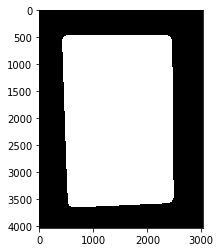

In [37]:
image = cv2.imread("../data/rimages/loan-117304-신분증앞면-1.jpeg")
annotation = cv2.imread("../data/annotations/loan-117304-신분증앞면-1.png")
plt.imshow(cv2.cvtColor(annotation[:, :, 2], cv2.COLOR_BGR2RGB))

In [38]:
annotation = annotation[:, :, 2]
annotation.shape

(4032, 3024)

In [22]:
image_extensions = dict()
annotation_extensions = dict()

IMAGE_DIR = "../data/rimages"
ANNOTATION_DIR = "../data/annotations"

# List all the image in the dataset
for _, _, files in os.walk(IMAGE_DIR):
    for filename in files:
        key, ext = filename.split(".")
        image_extensions[key] = ext

for _, _, files in os.walk(ANNOTATION_DIR):
    for filename in files:
        key, ext = filename.split(".")
        annotation_extensions[key] = ext

In [34]:
def mask2rle(image):
    """
    Convert mask to rle
    image: numpy array
    1 - mask,
    0 - background
    
    Returns run length as string formated
    """
    if not isinstance(image, np.ndarray):
        raise TypeError("image should be in np.ndarray type.")
        
    if np.max(image) == 255:
        print("Warning: Image should be converted to binary format.")
        image = image // 255
    
    pixels = image.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    
    return ' '.join(str(x) for x in runs)

# test if the implementation is correct
example = np.array(
    [
        [1, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 1]
    ]
).T
assert mask2rle(example) == '1 2 13 2'

1 2 13 2


In [51]:
encoded = maskUtils.encode(np.asfortranarray(annotation))
maskUtils.area(encoded)

6270953

In [54]:
def generate_image_description(key, extension, phase, height, width):
    return {
        "file_name": ".".join([key, extension]),
        "phiase": phase,
        "height": height,
        "width": width,
        "image_id": key
    }

def generate_segmentation_description(key, extension, annotation, idx):
    encoded = maskUtils.encode(np.asfortranarray(annotation))
    return {
        "segmentation": {
            "size": encoded["size"],
            "counts": encoded["counts"].decode("ascii")
        },
        "area": maskUtils.area(encoded),
        "iscrowd": 1,
        "image_id": key,
        "category_id": 1,
        "id": idx
    }

def generate_categories(supercategory, category_id, name):
    return {
        "supercategory": supercategory,
        "category_id": category_id,
        "name": name,
        "onlysemantic": 0,
        "parts": []
    }

In [71]:
def image_resize(image, width=None, height=None, inter=cv2.INTER_LANCZOS4):
    dim = None
    (h, w) = image.shape[:2]

    if width is None and height is None:
        return image
    try:
        if width is None:
            r = height / float(h)
            dim = (int(w * r), height)
            resized = cv2.resize(image, dim, interpolation=inter)
            resized = cv2.copyMakeBorder(resized, 0, 0, 0, height - dim[0], cv2.BORDER_CONSTANT, 0)
        else:
            r = width / float(w)
            dim = (width, int(h * r))
            resized = cv2.resize(image, dim, interpolation=inter)
            resized = cv2.copyMakeBorder(resized, 0, width - dim[1], 0, 0, cv2.BORDER_CONSTANT, 0)
    except Exception as e:
        print(width - dim[1], dim[1])
        raise e

    return resized


In [42]:
from sklearn.model_selection import train_test_split

valid_keys = list()
for key in image_extensions.keys():
    if annotation_extensions.get(key, None) is not None:
        # This is the valid example
        valid_keys.append(key)

train, test = train_test_split(valid_keys, test_size=0.1)

In [ ]:
from tqdm.notebook import tqdm

SAVE_IMAGE_DIR = "/dltraining/HRNet-Semantic-Segmentation/data/pascal_ctx/VOCdevkit/VOC_OCR/JPEGImages"
HEIGHT, WIDTH = 768, 768

train_test_dict = dict()

train_test_dict["categories"] = generate_categories("object", 1, "id_card")
train_test_dict["images"] = list()
train_test_dict["annos_segmentation"] = list()

for idx, key in tqdm(enumerate(train)):
    # read both image and label
    image = cv2.imread(os.path.join(IMAGE_DIR, ".".join([key, image_extensions[key]])))
    annotation = cv2.imread(os.path.join(ANNOTATION_DIR, ".".join([key, annotation_extensions[key]])))
    # resize image and label
    if image.shape != annotation.shape:
        continue
    height, width, channel = image.shape
    resized_image = np.zeros((HEIGHT, WIDTH, channel), dtype=image.dtype)
    resized_annotation = np.zeros((HEIGHT, WIDTH, channel), dtype=annotation.dtype)
    for c in range(channel):
        if height < width:
            resized_image[:, :, c] = image_resize(image[:, :, c], width=WIDTH)
            resized_annotation[:, :, c] = image_resize(annotation[:, :, c], width=WIDTH)
        else:
            resized_image[:, :, c] = image_resize(image[:, :, c], height=HEIGHT)
            resized_annotation[:, :, c] = image_resize(annotation[:, :, c], height=HEIGHT)

    resized_annotation = resized_annotation // 255
    resized_annotation = resized_annotation[:, :, 0]
    # append each instance
    train_test_dict["images"].append(generate_image_description(key, image_extensions[key], "train", HEIGHT, WIDTH))
    train_test_dict["annos_segmentation"].append(generate_segmentation_description(key, image_extensions[key], resized_annotation, idx))
    # save resized image
    cv2.imwrite(os.path.join(SAVE_IMAGE_DIR, ".".join([key, image_extensions[key]])), resized_image)

In [79]:
for idx, key in tqdm(enumerate(test)):
    # read both image and label
    image = cv2.imread(os.path.join(IMAGE_DIR, ".".join([key, image_extensions[key]])))
    annotation = cv2.imread(os.path.join(ANNOTATION_DIR, ".".join([key, annotation_extensions[key]])))
    # resize image and label
    if image.shape != annotation.shape:
        continue
    height, width, channel = image.shape
    resized_image = np.zeros((HEIGHT, WIDTH, channel), dtype=image.dtype)
    resized_annotation = np.zeros((HEIGHT, WIDTH, channel), dtype=annotation.dtype)
    for c in range(channel):
        if height < width:
            resized_image[:, :, c] = image_resize(image[:, :, c], width=WIDTH)
            resized_annotation[:, :, c] = image_resize(annotation[:, :, c], width=WIDTH)
        else:
            resized_image[:, :, c] = image_resize(image[:, :, c], height=HEIGHT)
            resized_annotation[:, :, c] = image_resize(annotation[:, :, c], height=HEIGHT)

    resized_annotation = resized_annotation // 255
    resized_annotation = resized_annotation[:, :, 0]
    # append each instance
    train_test_dict["images"].append(generate_image_description(key, image_extensions[key], "val", HEIGHT, WIDTH))
    train_test_dict["annos_segmentation"].append(generate_segmentation_description(key, image_extensions[key], resized_annotation, idx))
    cv2.imwrite(os.path.join(SAVE_IMAGE_DIR, ".".join([key, image_extensions[key]])), resized_image)

In [80]:
train_test_dict

{'categories': {'supercategory': 'object',
  'category_id': 1,
  'name': 'id_card',
  'onlysemantic': 0,
  'parts': []},
 'images': [{'file_name': 'loan-125185-신분증앞면-1.jpg',
   'phiase': 'train',
   'height': 768,
   'width': 768,
   'image_id': 'loan-125185-신분증앞면-1'},
  {'file_name': 'loan-123910-신분증앞면-1.jpg',
   'phiase': 'train',
   'height': 768,
   'width': 768,
   'image_id': 'loan-123910-신분증앞면-1'},
  {'file_name': 'loan-127953-신분증앞면-1.jpg',
   'phiase': 'train',
   'height': 768,
   'width': 768,
   'image_id': 'loan-127953-신분증앞면-1'},
  {'file_name': 'loan-128426-신분증앞면-1.jpg',
   'phiase': 'train',
   'height': 768,
   'width': 768,
   'image_id': 'loan-128426-신분증앞면-1'},
  {'file_name': 'loan-130911-신분증앞면-1.jpeg',
   'phiase': 'train',
   'height': 768,
   'width': 768,
   'image_id': 'loan-130911-신분증앞면-1'},
  {'file_name': 'loan-122506-신분증앞면-2.jpg',
   'phiase': 'train',
   'height': 768,
   'width': 768,
   'image_id': 'loan-122506-신분증앞면-2'},
  {'file_name': 'loan-129860-신분증앞면